# Exercise 1

## 1.1

In [1]:
@enum InfectionStatus S I R

In [2]:
x = S

S::InfectionStatus = 0

In [3]:
typeof(x)

Enum InfectionStatus:
S = 0
I = 1
R = 2

In [4]:
x == S

true

## 1.2

In [5]:
Int(x)

0

x has value 0. I and R are associated with values 1 and 2, respectively.

## 1.3

In [6]:
N = 100

agents = [S for i in 1:N]

100-element Array{InfectionStatus,1}:
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 ⋮
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S
 S

## 1.4

In [7]:
i = rand(1:100)

agents[i] = I

I::InfectionStatus = 1

## 1.5

In [8]:
function step!(agents, p_I) #looking at just 1 random agent, probability that another one gets infected
    i = rand(1:N)
    if agents[i] != I #nothing happens if i is not infected
        return
    end
    
    j = rand(1:N)   #find j that is not infected
    while i==j
        j = rand(1:N)
    end
    
    infected = rand() < p_I #probability p_I that i infects j
    if infected && agents[j] != I
        agents[j] = I
    end
end   

step! (generic function with 1 method)

## 1.6

In [9]:
function sweep!(agents, p_I, N) #runs step! on all agents. how many are infected after each one on average has had a chance to infect another one?
    for i in 1:N
        step!(agents, p_I)
    end
end

sweep! (generic function with 1 method)

## 1.7

In [10]:
function infection_simulation(N, p_I, T)
    agents = [S for i in 1:N]
    Is = zeros(T)
    
    i = rand(1:N) #a random agent starts as infected
    agents[i] = I
    
    for x in 1:T #T sweeps of agents. runs infection through entire agents array T times
        sweep!(agents, p_I, N)
        Is[x] = count(num -> num==I, agents)
    end
    
    return Is #number of infected agents after each sweep
end

infection_simulation (generic function with 1 method)

## 1.8

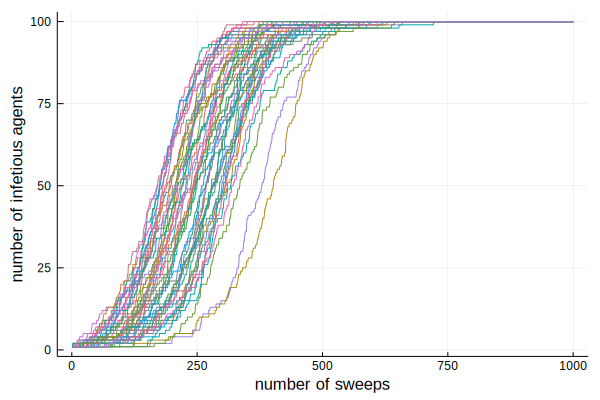

In [11]:
using Plots

results = Array[] #array of arrays containing num infected agents for each simulation after each sweep

for i in 1:50
    result = infection_simulation(100, 0.02, 1000)
    push!(results, result)
end

p = plot(xlabel = "number of sweeps", ylabel = "number of infetious agents", alpha = 0.5, leg = false)
for result in results
    plot!(result)
end
p

## 1.9

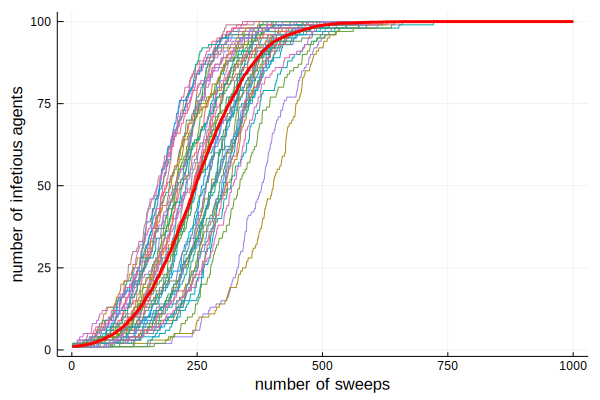

In [12]:
using Statistics
meanTraj = mean(results)

plot!(meanTraj, lw = 3, c=:red)
#plot!(yerror=σ, c=:blue, alpha = 0.5)

## 1.10

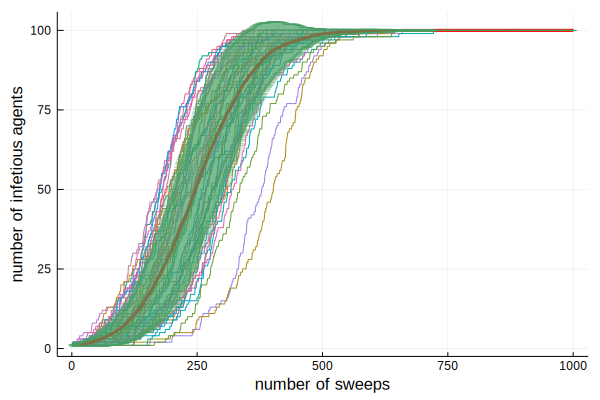

In [13]:
σ = std(results)

plot!(meanTraj, lw=3, linecolor=:red, yerror=σ, fillcolor=:blue, alpha=0.5)


## 1.11

The deterministic value describes the expected values/results of the stochastic model.

# Exercise 2

## 2.1

In [14]:
mutable struct Agent
    status::InfectionStatus
    num_infected::Int
end

## 2.2

In [15]:
Agent() = Agent(S, 0)

Agent

## 2.3

In [16]:
function step!(agents::Vector{Agent}, p_I) #looking at just 1 random agent, probability that another one gets infected
    i = rand(1:length(agents))
    if agents[i].status != I #nothing happens if i is not infected
        return
    end
    
    j = rand(1:length(agents))   #find j that is not infected
    while i==j
        j = rand(1:length(agents))
    end
    
    infected = rand() < p_I #probability p_I that i infects j
    if infected && agents[j].status != I
        agents[j].status = I
        agents[i].num_infected += 1
    end
end   

step! (generic function with 2 methods)

In [17]:
function sweep!(agents::Vector{Agent}, p_I, N) #runs step! on all agents. how many are infected after each one on average has had a chance to infect another one?
    for i in 1:N
        step!(agents, p_I)
    end
end

sweep! (generic function with 2 methods)

In [18]:
function cts(agents::Vector{Agent})
    d = Dict{Int, Int}() #num_infected count --> number of times that count appears in agents
    
    for i in 1:length(agents)
        if haskey(d, agents[i].num_infected)
            d[agents[i].num_infected] += 1
        else
            d[agents[i].num_infected] = 1
        end
    end
    
    ks = collect(keys(d))
    vs = collect(values(d))
    p = sortperm(ks)
    ks_sorted = ks[p]
    vs_sorted = vs[p]
    
    return ks_sorted, vs_sorted
end

function probability_distribution(agents::Vector{Agent})
    c = cts(agents)
    
    totalCounts = sum(c[2])
    frequencies = [c[2][i]/totalCounts for i in 1:length(c[2])]   #each entry in frequency = proportion of that number's count in total count
    
    return c[1], frequencies
end

probability_distribution (generic function with 1 method)

In [19]:
function num_infected_dist_simulation(N, p_I, T)
    agents = [Agent() for i in 1:N]
    Is = zeros(T)
    
    #i = rand(1:100) #a random agent starts as infected
    agents[1].status = I
    
    for x in 1:T #T sweeps of agents. runs infection through entire agents array T times
        sweep!(agents, p_I, N)
        Is[x] = count(num -> num==I, [agents[i].status for i in 1:N])
    end
    
    probDist = probability_distribution(agents) #prob distribution of the number of other agents that each agent infects
    
    return probDist #1st element: distinct num_infected values. 2nd element: frequency that that count appears
end

num_infected_dist_simulation (generic function with 1 method)

## 2.6

In [20]:
results = [] #array of arrays prob dist of num_infected for each simulation after each sweep

for i in 1:50
    result = num_infected_dist_simulation(100, 0.02, 1000)
    push!(results, result)
end

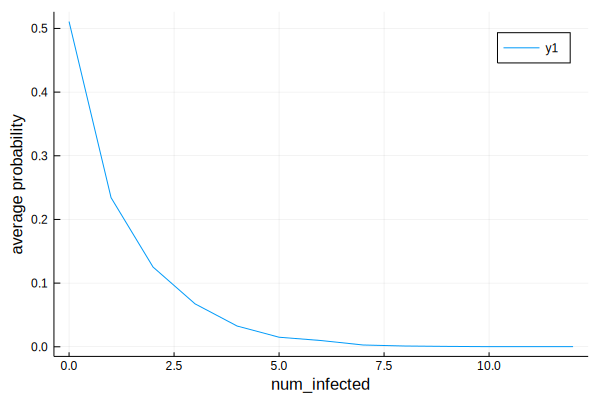

In [21]:
num_infected_values = Int64[] #first make a vector with the num_infected counts that appear in the results
for result in results
    for i in 1:length(result[1]) #loop thru all results and get the vector of count appearances
        if (result[1][i] in num_infected_values) == false
            push!(num_infected_values, result[1][i]) #add each count to num_infected_values if not already in there
        end
    end
end
sort!(num_infected_values)

avg_dist = [] #get the average distribution frequency for each distinct num_infected value over all results
for value in num_infected_values
    frequencies = []
    for result in results
        if value in result[1]
            i = findfirst(isequal(value), result[1]) #get the index of where 'value' appears in the result array of values
            push!(frequencies, result[2][i]) #add frequency corresponding with 'value' to vector
        else
            push!(frequencies, 0) #if 'value' dne, add 0
        end
    end
    push!(avg_dist, mean(frequencies)) #add the mean of the frequencies to overall list
end

pl = plot(num_infected_values, avg_dist, xlabel = "num_infected", ylabel = "average probability")

The distribution seems to be an exponential (decay)

# Exercise 3

## 3.1

In [22]:
a = Agent()

Agent(S, 0)

In [23]:
a.status == S


true

In [24]:
function step!(agents::Vector{Agent}, p_I) #looking at just 1 random agent, probability that another one gets infected
    i = rand(1:length(agents)) #pick a random agent
    if agents[i].status != I #nothing happens if i is not infected
        return
    end
    
    j = rand(1:length(agents))   #find j that is not infected
    while i==j
        j = rand(1:length(agents))
    end
    
    infected = rand() < p_I #probability p_I that i infects j
    if (agents[j].status == S) && infected
        agents[j].status = I
        agents[i].num_infected += 1
    end
end 

step! (generic function with 2 methods)

In [64]:
function sweep!(agents::Vector{Agent}, p_I, p_R, N) #runs step! on all agents. how many are infected after each one on average has had a chance to infect another one?
    for i in 1:N
        step!(agents, p_I)
        recovered = rand() < p_R
        if (agents[i].status == I) && recovered
            agents[i].status = R
        end
    end

end

sweep! (generic function with 3 methods)

In [65]:
function simulation_with_recovery(N, p_I, p_R, T)
    agents = [Agent() for i in 1:N]
    Is = zeros(T)
    Ss = zeros(T)
    Rs = zeros(T)
    
    agents[1].status = I
    
    for x in 1:T #T sweeps of agents. runs infection through entire agents array T times
        sweep!(agents, p_I, p_R, N)
        Is[x] = count(num -> num==I, [agents[i].status for i in 1:N])
        Ss[x] = count(num -> num==S, [agents[i].status for i in 1:N])
        Rs[x] = count(num -> num==R, [agents[i].status for i in 1:N])
    end
    
    probDist = probability_distribution(agents) #prob distribution of the number of other agents that each agent infects
    
    return probDist, Ss, Is, Rs
end

simulation_with_recovery (generic function with 1 method)

## 3.2

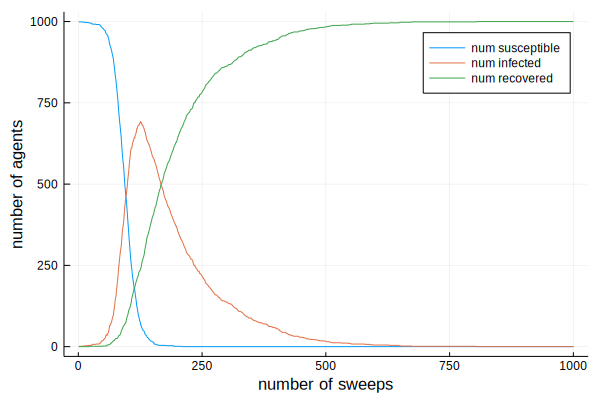

In [69]:
results = simulation_with_recovery(1000, 0.1, 0.01, 1000)

p = plot(results[2], label = "num susceptible", xlabel = "number of sweeps", ylabel = "number of agents")
plot!(results[3], label = "num infected")
plot!(results[4], label = "num recovered")

## 3.3 

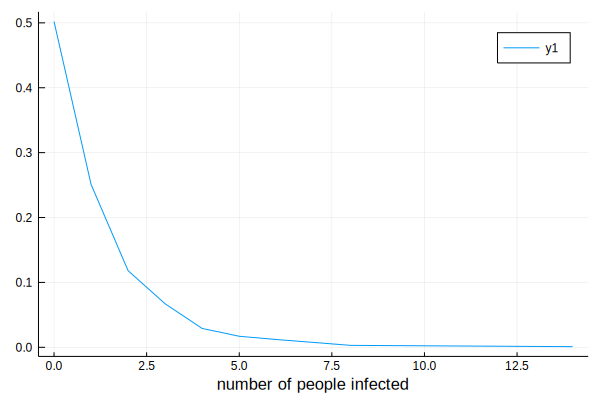

In [71]:
numInfected = plot(results[1][1], results[1][2], xlabel = "number of people infected")

The shape is that of an exponential decay distribution

## 3.4

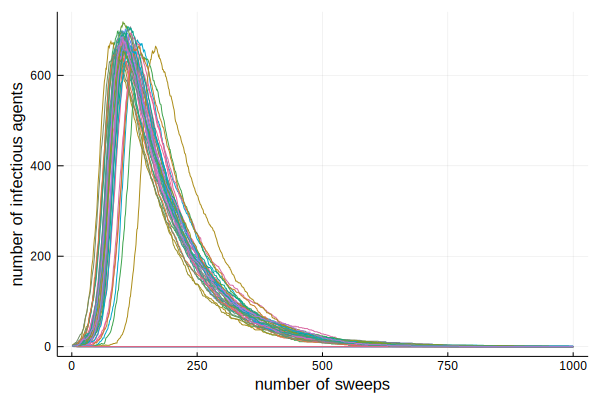

In [70]:
infections = Array[] #array of arrays containing num infected agents for each simulation after each sweep

for i in 1:50
    result = simulation_with_recovery(1000, 0.1, 0.01, 1000)[3]
    push!(infections, result)
end

y = plot(xlabel = "number of sweeps", ylabel = "number of infectious agents", alpha = 0.5, leg = false)
for result in infections
    plot!(result)
end
y

## 3.5

The epidemic peake at around 700 infectious agents out of 1000. It takes around 750 sweeps for all people to recover. The number of susceptible people (people who have never been affected by the epidemic) drops to 0 after about 150 days.